In [1]:
!pip install --q ipython-autotime
%load_ext autotime

time: 823 µs (started: 2024-09-11 01:10:58 +00:00)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

time: 1.29 s (started: 2024-09-11 01:11:34 +00:00)


In [3]:
import tensorflow as tf
import keras

time: 3.2 s (started: 2024-09-11 01:11:40 +00:00)


In [4]:
from keras.datasets import fashion_mnist

time: 1.91 ms (started: 2024-09-11 01:11:47 +00:00)


In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() # 실습을 위한 데이터가 라이브러리에 이미 존재함
print(X_train.shape, y_train.shape) # 훈련과 검증 데이터가 6:1의 비율로 존재
print(X_test.shape, y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
time: 1.9 s (started: 2024-09-11 01:12:50 +00:00)


In [6]:
columns = ['T-shirt/top', 'Trouser',  'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

time: 489 µs (started: 2024-09-11 01:13:31 +00:00)


In [7]:
np.random.seed(42)
sample = np.random.randint(60000, size= 25) # 25개만 랜덤 추출
sample

array([56422, 15795,   860, 38158, 54343, 44732, 11284, 54886,  6265,
       16850, 37194, 21962, 47191, 44131, 16023, 41090,  1685,   769,
       59735, 56101,  2433,  5311, 37819, 39188, 17568])

time: 7.52 ms (started: 2024-09-11 01:14:40 +00:00)


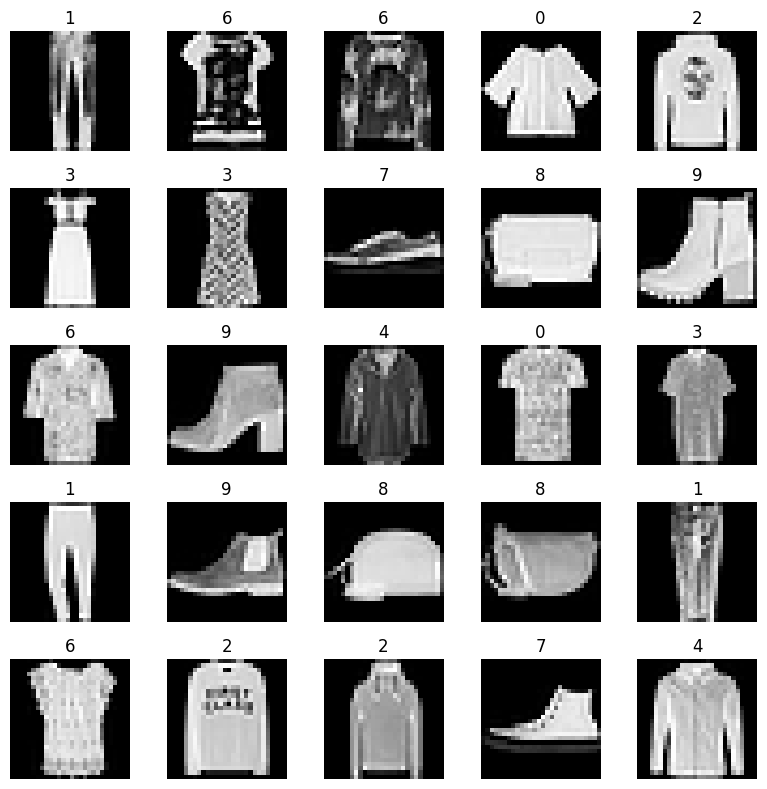

time: 1.5 s (started: 2024-09-11 01:15:45 +00:00)


In [8]:
fig = plt.figure(figsize=(8,8))
for i, idx in enumerate(sample):
  plt.subplot(5, 5, i+1) # i는 0부터 시작하므로
  plt.imshow(X_train[idx], cmap='gray') # X_train 속 데이터를 흑백으로 보자
  plt.axis('off')
  plt.title(y_train[idx])
fig.tight_layout()
plt.show()

In [10]:
pd.Series(y_train).value_counts().sort_index() # 테스트 데이터의 구성 보기

,count
0,6000
1,6000
2,6000
3,6000
4,6000
5,6000
6,6000
7,6000
8,6000
9,6000


time: 23.2 ms (started: 2024-09-11 01:16:17 +00:00)


## 3. 학습용, 검증용 데이터 분리

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state= 42) # 훈련 데이터를 4:1의 비율로 한 번 더 분리
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(48000, 28, 28) (48000,)
(12000, 28, 28) (12000,)
time: 270 ms (started: 2024-09-11 01:20:06 +00:00)


## 4. 전처리
- X_train, X_val: Min-Max 스케일링
- y_train, y_val: one hot encoding

In [12]:
# minmaxscaling: X - Xmin / Xmax - Xmin -> 이건데 Xmin은 0이고 Xmax는 255라서 그냥 255로 나누면 됨.
X_train_s = X_train / 255.
X_val_s = X_val / 255.

time: 118 ms (started: 2024-09-11 01:20:52 +00:00)


In [13]:
# y의 one-hot encoding
from keras.utils import to_categorical

y_train_o = to_categorical(y_train)
y_val_o = to_categorical(y_val)

time: 7.22 ms (started: 2024-09-11 01:22:23 +00:00)


In [14]:
print(X_train_s.shape, X_val_s.shape, y_train_o.shape, y_val_o.shape) # 카테고리가 10개이므로 10개로 나눠짐

(48000, 28, 28) (12000, 28, 28) (48000, 10) (12000, 10)
time: 1.75 ms (started: 2024-09-11 01:23:13 +00:00)


## 5. 모델
- CNN model

In [15]:
X_train_s = X_train_s.reshape(-1, 28, 28, 1) # 아무리 흑백이라도 합성곱 신경망에서는 2차원 데이터를 사용해야 함 그게 cnn의 존재 이유.
X_val_s = X_val_s.reshape(-1, 28, 28, 1)

X_train_s.shape, X_val_s.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

time: 3.71 ms (started: 2024-09-11 01:25:01 +00:00)


In [16]:
from keras import layers

model = keras.Sequential(
    [
        layers.Conv2D(filters= 16, # 필터의 개수; 이는 16개의 피쳐 맵을 형성함.
                      kernel_size= 3, # 필터의 크기를 의미
                      activation= 'relu',
                      input_shape= (28, 28, 1) # input shape를 튜플 형식으로 보낼 수 있음.
        ),
        layers.MaxPool2D(), # 반절로 풀링하고
        layers.Conv2D(filters= 32,
                      kernel_size= 3,
                      activation= 'relu'
        ),
        layers.MaxPool2D(),
        layers.Flatten(), # 쭉 펴줌
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation= 'softmax')
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


time: 1.05 s (started: 2024-09-11 02:15:43 +00:00)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,618 (424.29 KB)

 Trainable params: 108,618 (424.29 KB)

 Non-trainable params: 0 (0.00 B)

time: 23 ms (started: 2024-09-11 02:15:51 +00:00)


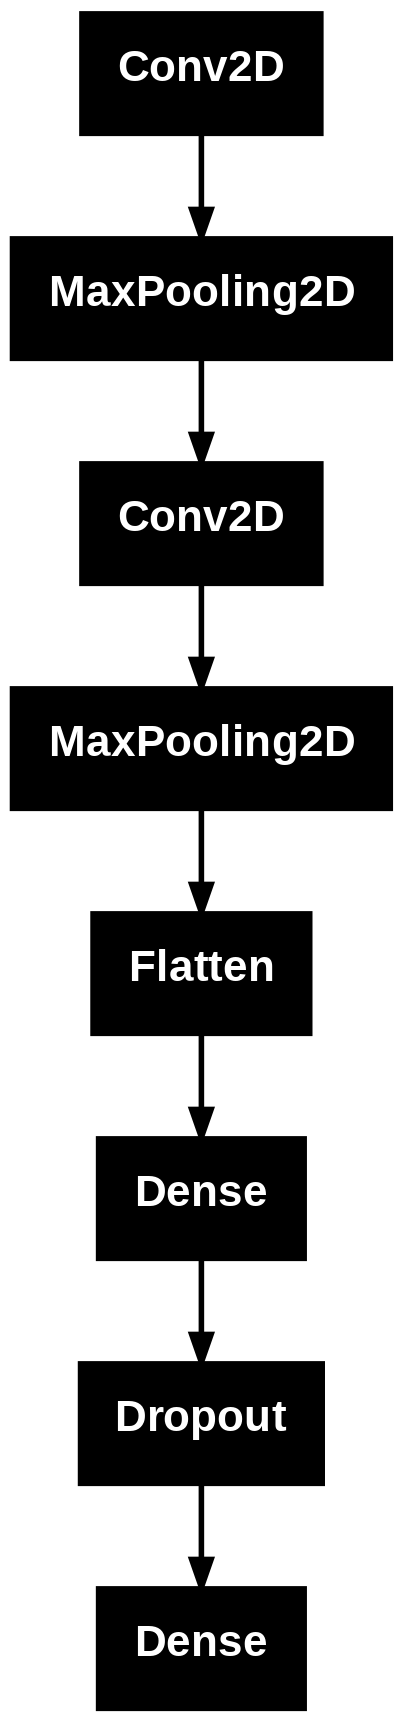

time: 295 ms (started: 2024-09-11 02:17:44 +00:00)


In [18]:
keras.utils.plot_model(model)

In [19]:
model.compile(
    optimizer= 'adam',
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

time: 17.9 ms (started: 2024-09-11 02:17:49 +00:00)


In [20]:
epochs = 30
bach_size = 32

history = model.fit(
    X_train_s, y_train_o,
    epochs= epochs,
    batch_size= bach_size,
    validation_data= (X_val_s, y_val_o)
)

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7223 - loss: 0.7719 - val_accuracy: 0.8513 - val_loss: 0.4029
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8554 - loss: 0.3935 - val_accuracy: 0.8622 - val_loss: 0.3641
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8769 - loss: 0.3394 - val_accuracy: 0.8855 - val_loss: 0.3130
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8882 - loss: 0.3040 - val_accuracy: 0.8938 - val_loss: 0.2827
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8992 - loss: 0.2792 - val_accuracy: 0.8975 - val_loss: 0.2711
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9033 - loss: 0.2580 - val_accuracy: 0.9012 - val_loss: 0.2790
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9101 - loss: 0.2402 - val_accuracy: 0.9018 - val_loss: 0.2698
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9184 - loss: 0.2183 -

In [21]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

time: 805 µs (started: 2024-09-11 02:20:27 +00:00)


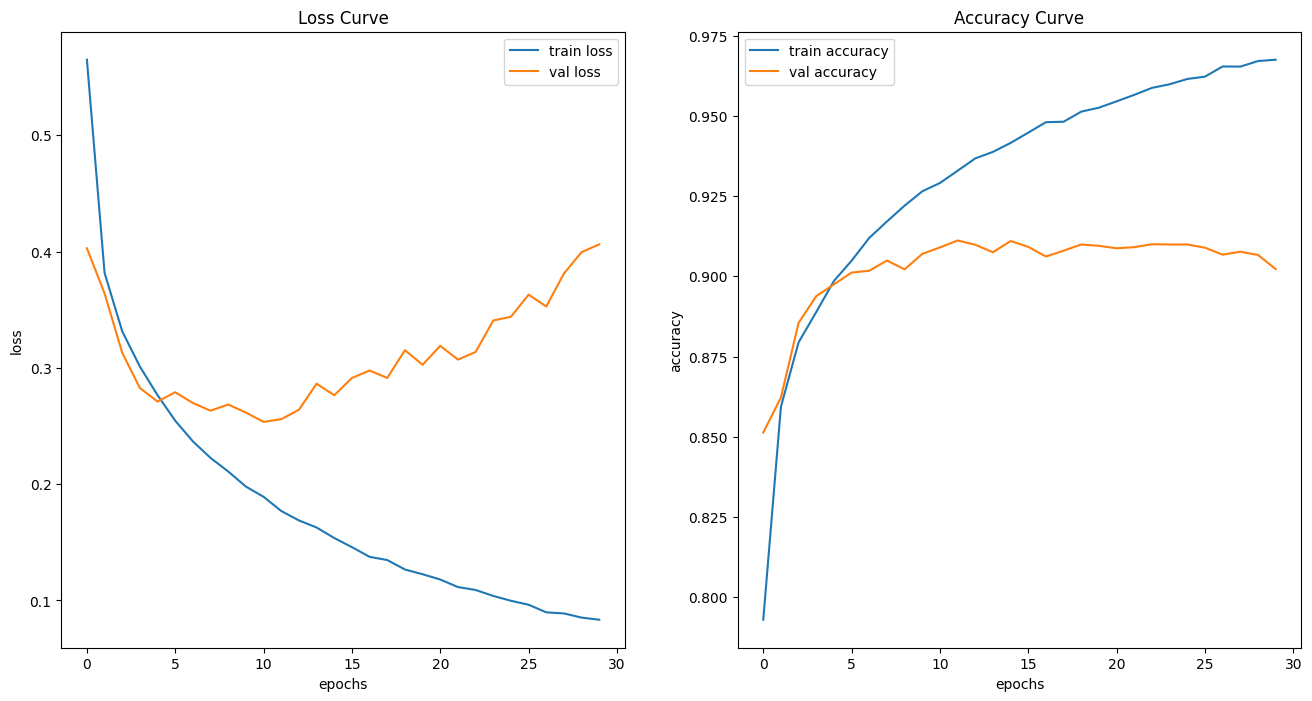

time: 448 ms (started: 2024-09-11 02:20:32 +00:00)


In [22]:
plot_history(history)

In [23]:
X_test_s = X_test / 255. # 테스트 데이터도 스케일링 해주고
X_test_s = X_test.reshape(-1, 28, 28, 1)
y_test_o = to_categorical(y_test)

time: 30.9 ms (started: 2024-09-11 02:20:59 +00:00)


In [24]:
y_pred = model.predict(X_test_s) # 예측하기

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
time: 5.22 s (started: 2024-09-11 02:21:05 +00:00)


In [25]:
y_pred = np.argmax(y_pred, axis= 1)
y_pred

array([9, 2, 1, ..., 8, 1, 5])

time: 6.24 ms (started: 2024-09-11 02:21:30 +00:00)


accuracy: 0.7879
recall: 0.7879
precision: 0.8072175756588708
f1: 0.7888305092560731


<Axes: >

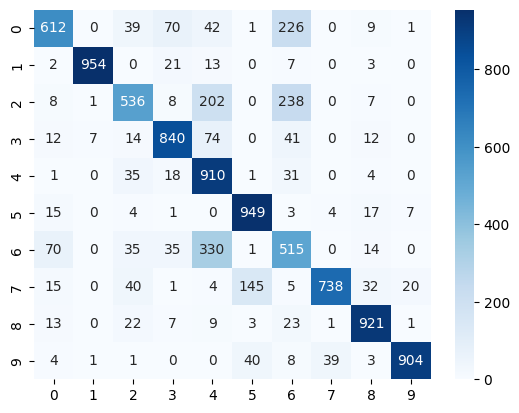

time: 484 ms (started: 2024-09-11 02:22:22 +00:00)


In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'recall: {recall_score(y_test, y_pred, average="macro")}')
print(f'precision: {precision_score(y_test, y_pred, average="macro")}')
print(f'f1: {f1_score(y_test, y_pred, average="macro")}')

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')

In [27]:
sample = np.random.randint(10000, size= 25)

time: 1.08 ms (started: 2024-09-11 02:22:28 +00:00)


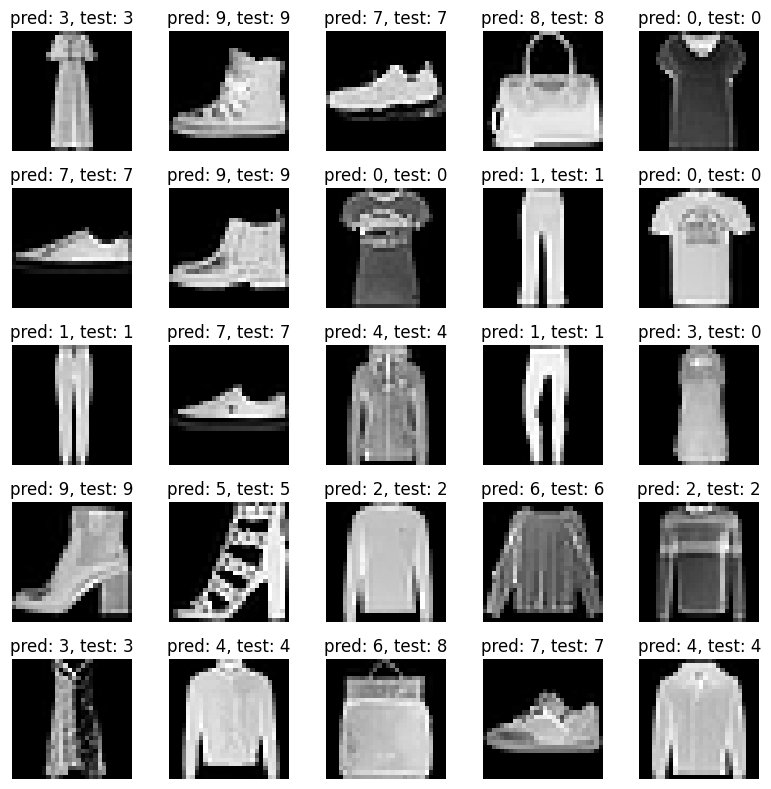

time: 1.93 s (started: 2024-09-11 02:22:32 +00:00)


In [28]:
fig = plt.figure(figsize=(8,8))
for i, idx in enumerate(sample):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_test[idx], cmap='gray')
  plt.axis('off')
  plt.title(f'pred: {y_pred[idx]}, test: {y_test[idx]}')
fig.tight_layout()
plt.show()

## 모델 저장

In [29]:
model.save('cnn_multi_fashion.h5')

time: 56.2 ms (started: 2024-09-11 02:23:07 +00:00)


In [30]:
model.save('cnn_multi_fashion.keras')

time: 40.7 ms (started: 2024-09-11 02:23:10 +00:00)


In [32]:
loaded_model = keras.saving.load_model('/content/cnn_multi_fashion.h5')

time: 300 ms (started: 2024-09-11 02:23:32 +00:00)


In [33]:
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,620 (424.30 KB)

 Trainable params: 108,618 (424.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

time: 26.3 ms (started: 2024-09-11 02:23:37 +00:00)
